<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
# !pip install ./deepul
from deepul.hw2_helper import *

# change working directory so the starter code can find the data
import os
# os.chdir('../../../')
# os.getcwd()

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


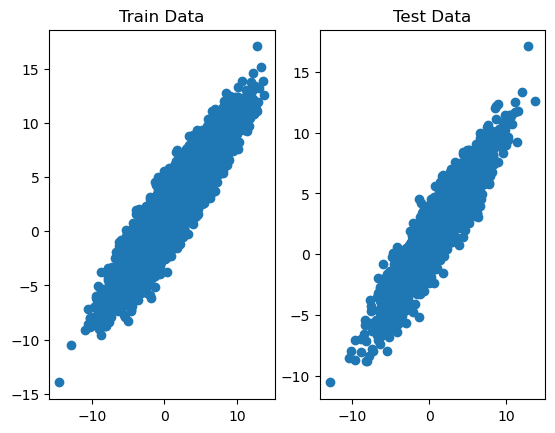

Dataset 2


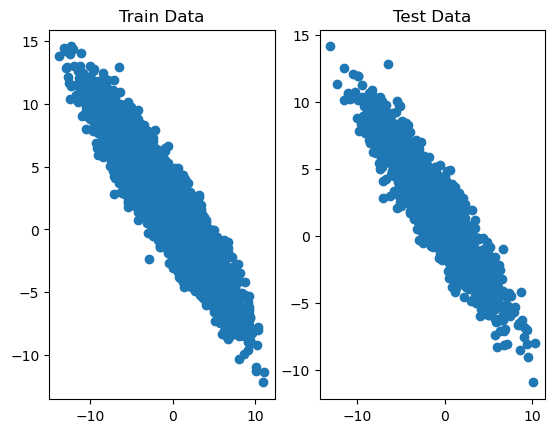

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




## Common Util Functions

In [4]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm
from torch.distributions import Normal, kl_divergence
import math
import copy
from dataclasses import dataclass
import time

quiet = True

"""
Util functions are adapted from staff solution of HW1
"""

def train_vae(model, train_loader, optimizer, scheduler, epoch, grad_clip=None):
    model.train()
  
    train_losses = np.zeros((len(train_loader), 3))
    for i, x in enumerate(train_loader):
        x = x.cuda().contiguous()
        neg_elbo, recon_loss, kl_loss = model.loss(x)
        optimizer.zero_grad()
        neg_elbo.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        train_losses[i, 0] = neg_elbo.item()
        train_losses[i, 1] = recon_loss.item()
        train_losses[i, 2] = kl_loss.item()
    return train_losses


def eval_loss_vae(model, data_loader):
    model.eval()
    total_elbo, total_recon_loss, total_kl = 0, 0, 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda().contiguous()
            neg_elbo, recon_loss, kl_loss = model.loss(x)
            total_elbo += neg_elbo * x.shape[0]
            total_recon_loss += recon_loss * x.shape[0]
            total_kl += kl_loss * x.shape[0]
            avg_elbo = total_elbo / len(data_loader.dataset)
            avg_recon_loss = total_recon_loss / len(data_loader.dataset)
            avg_kl = total_kl / len(data_loader.dataset)
        loss = np.array([avg_elbo.item(), avg_recon_loss.item(), avg_kl.item()])
        return loss[np.newaxis, :]


def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    if step < warmup_steps:
        # Linear warmup
        mul = (step + 1) / warmup_steps
        return mul
    else:
        # Cosine decay
        if use_cos_decay:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return (1 + math.cos(math.pi * progress)) / 2
        else:
            return 1


def train_epochs_vae(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    warmup_steps = train_args.get('warmup', 0)
    use_cos_decay = train_args.get('use_cos_decay', False)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )

    test_losses = eval_loss_vae(model, test_loader)
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        train_loss = train_vae(model, train_loader, optimizer, scheduler, epoch, grad_clip)
        if epoch == 0:
            train_losses = train_loss
        else:
            train_losses = np.append(train_losses, train_loss, axis=0)
        test_loss = eval_loss_vae(model, test_loader)
        test_losses = np.append(test_losses, test_loss, axis=0)
        if not quiet:
            train_elbo = train_loss[:, 0].mean()
            test_elbo = test_loss[0, 0]
            print(f'Epoch {epoch}, Train loss {train_elbo:.4f}, Test loss {test_elbo:.4f}')

    return train_losses, test_losses

In [5]:
def train(model, train_loader, optimizer, scheduler, epoch, grad_clip=None):
    model.train()
    
    train_losses = []
    for x in train_loader:
        x = x.cuda().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)

    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    warmup_steps = train_args.get('warmup', 0)
    use_cos_decay = train_args.get('use_cos_decay', False)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    total_steps = epochs * len(train_loader)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer, 
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        train_losses.extend(train(model, train_loader, optimizer, scheduler, epoch, grad_clip))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        if not quiet:
            print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [6]:
class VAE2D(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_dim = 128
        self.input_dim = 2
        self.latent_dim = 2
        # encoder: x --> z ~ mu(x), log_sigma(x)
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.latent_dim * 2)
        )
        # decoder: z --> x ~ mu(z), log_sigma(z)
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.input_dim * 2)
        )

    def forward(self, x):
        B = x.size(0)
        # mu_z, log_sigma_z: [B, 2]
        mu_z, sigma_z = self.encoder(x).split(self.latent_dim, dim=1)
        sigma_z = F.softplus(sigma_z)
        # the r.v. z ~ q(z | x)
        m = Normal(mu_z, sigma_z)
        # implements the reparameterization trick internally
        # by sampling from N(0, 1) then shift and scaled by mu and sigma
        # [B, 2]
        z = m.rsample()

        # mu_x, log_sigma_x: [B, 2]
        mu_x, sigma_x = self.decoder(z).split(self.latent_dim, dim=1)
        sigma_x = F.softplus(sigma_x)

        return mu_z, sigma_z, mu_x, sigma_x

    def loss(self, x):
        """
        Returns:
            neg_elbo: full negative ELBO
            recon_loss: E[-p(x|z)],
            kl_loss: E[KL(q(z|x) | p(z))]
        """
        mu_z, sigma_z, mu_x, sigma_x = self(x)
        
        # the r.v. x ~ p(x | z)
        rv_x = Normal(mu_x, sigma_x)
        # log p(x | z)
        pxz = rv_x.log_prob(x)

        # the r.v. z ~ q(z | x)
        rv_qz = Normal(mu_z, sigma_z)
        # the r.v. z ~ p(z) = N(0, 1)
        rv_pz = Normal(torch.full_like(mu_z, 0), torch.full_like(sigma_z, 1))

        recon_loss = -pxz.mean()
        kl_loss = kl_divergence(rv_qz, rv_pz).mean()
        neg_elbo = recon_loss + kl_loss
        return neg_elbo, recon_loss, kl_loss

    @torch.no_grad
    def sample(self, n_samples, with_decoder_noise: bool):
        # z ~ N(0, 1), [B, 2]
        z = torch.normal(0, 1, (n_samples, 2)).cuda()
        mu_x, sigma_x = self.decoder(z).split(self.latent_dim, dim=1)
        sigma_x = F.softplus(sigma_x)
        if with_decoder_noise:
            x = torch.normal(mu_x, sigma_x)
        else:
            x = mu_x
        return x.detach().cpu().numpy()

In [7]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """
    model = VAE2D().cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_args = dict(epochs=10, lr=1e-2)
    train_losses, test_losses = train_epochs_vae(
        model, train_loader, test_loader, train_args)
    samples_with_noise = model.sample(1000, with_decoder_noise=True)
    samples_without_noise = model.sample(1000, with_decoder_noise=False)
    return train_losses, test_losses, samples_with_noise, samples_without_noise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

Final -ELBO: 2.2903, Recon Loss: 1.5239, KL Loss: 0.7665


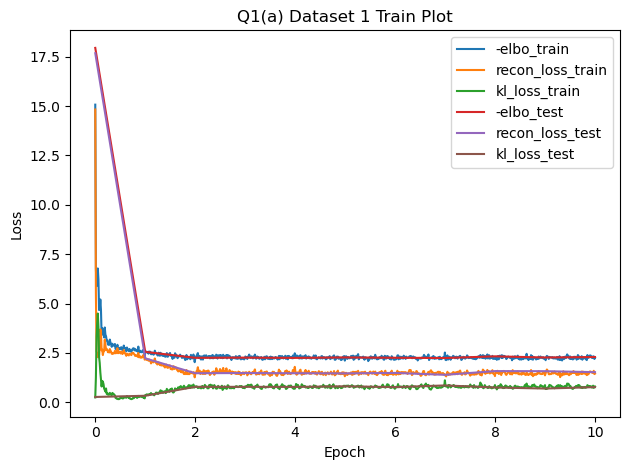

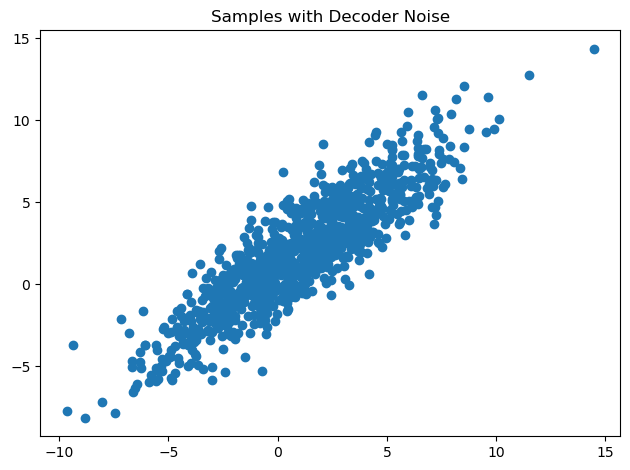

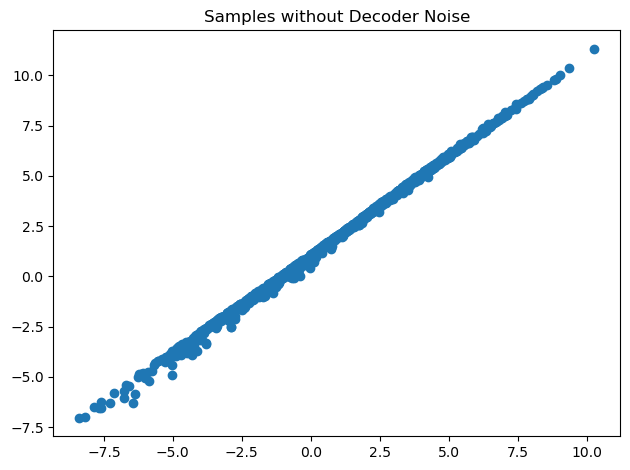

In [8]:
q1_save_results('a', 1, q1)

100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

Final -ELBO: 2.2151, Recon Loss: 1.4367, KL Loss: 0.7784


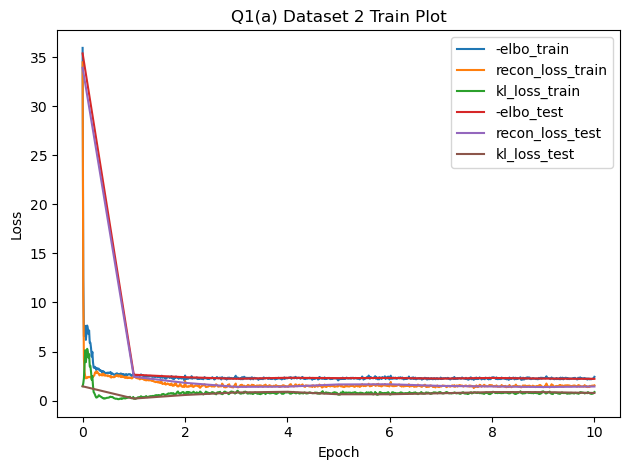

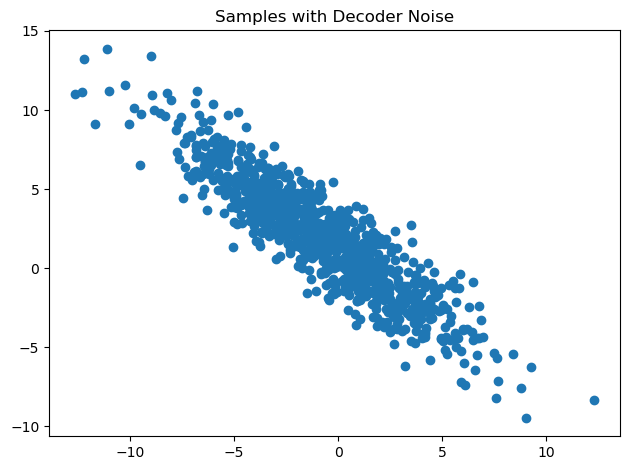

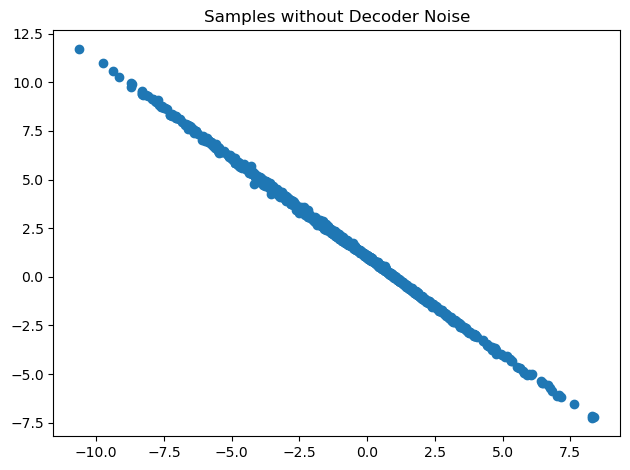

In [9]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


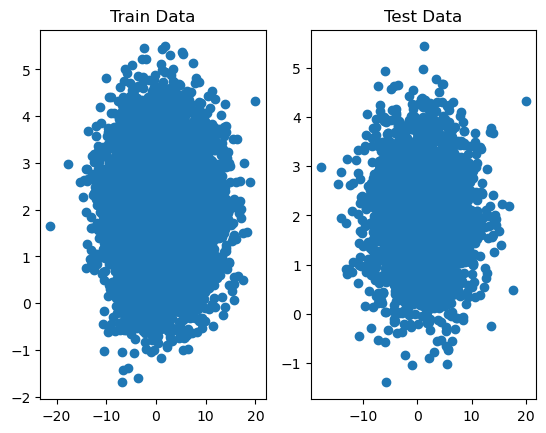

Dataset 2


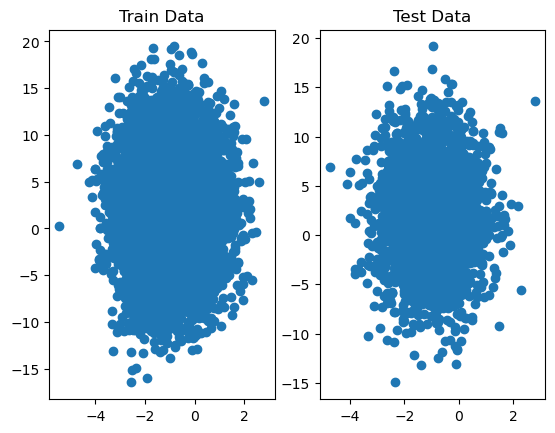

In [72]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

Final -ELBO: 2.2186, Recon Loss: 2.2080, KL Loss: 0.0107


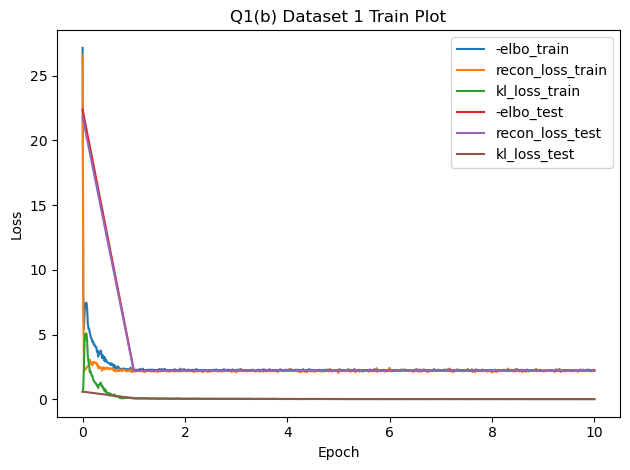

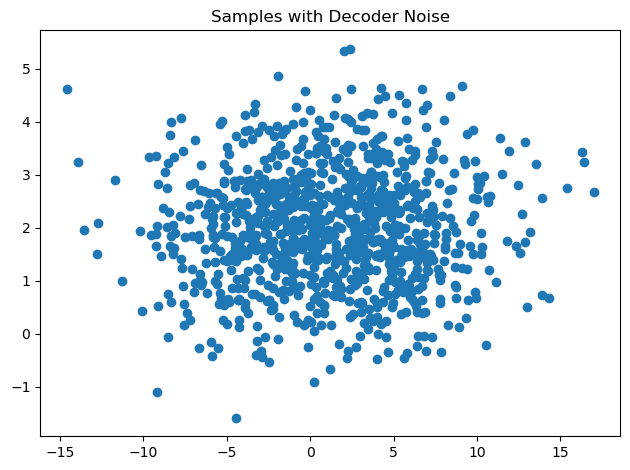

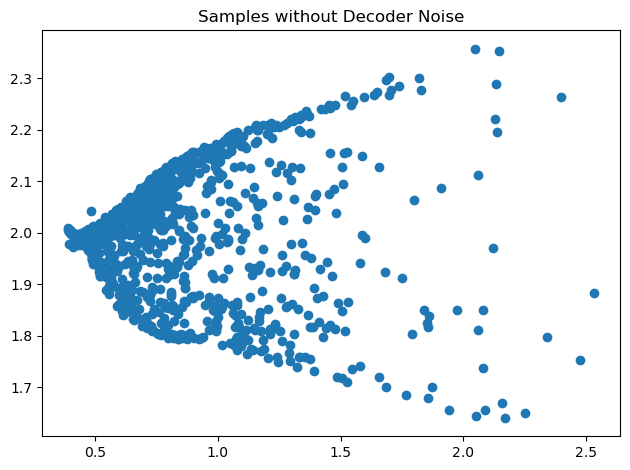

In [10]:
q1_save_results('b', 1, q1)

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

Final -ELBO: 2.2184, Recon Loss: 2.2066, KL Loss: 0.0118


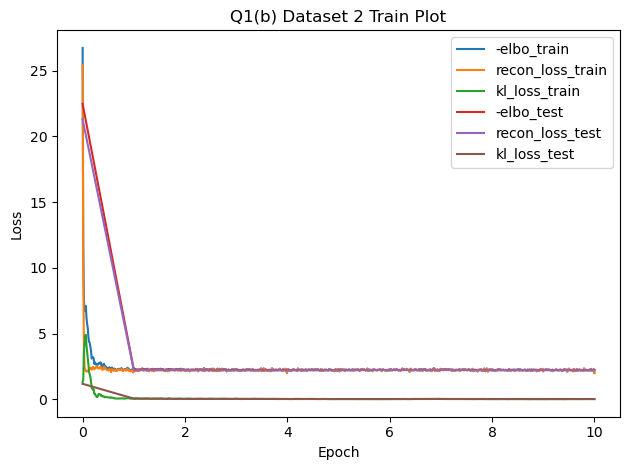

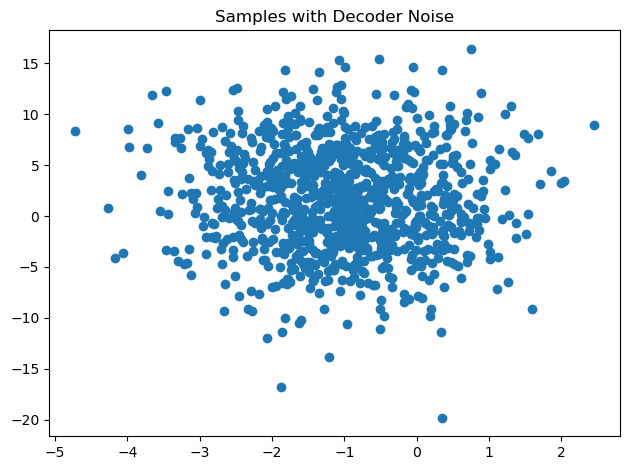

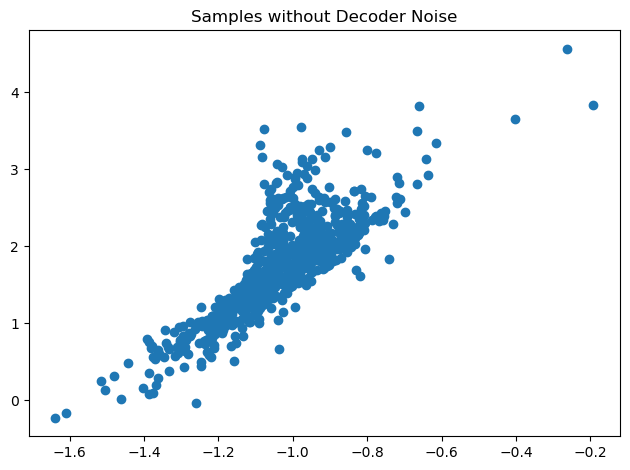

In [11]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

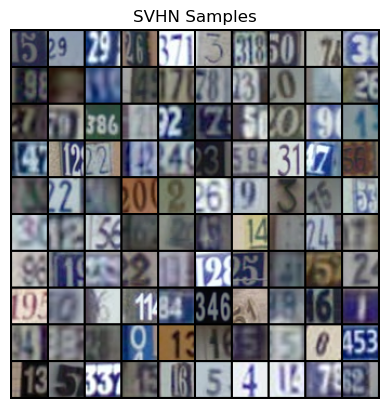

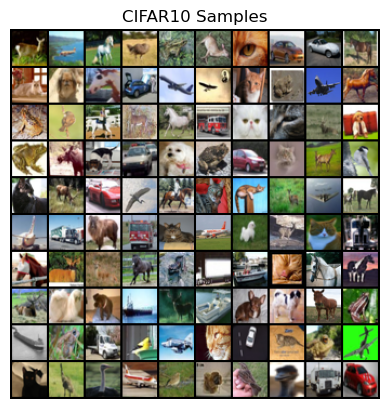

In [12]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [13]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.latent_dim = 16
        
        # encoder: x --> z ~ mu(x), log_sigma(x)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
            nn.ReLU(),
            nn.Flatten(), # 16
            nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        )
        # decoder: z --> x ~ mu(z), log_sigma(z)
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 4 * 4 * 128),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)), # 4 x 4
            nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        B = x.size(0)
        # mu_z, log_sigma_z: [B, 16]
        mu_z, sigma_z = self.encoder(x).split(self.latent_dim, dim=1)
        sigma_z = F.softplus(sigma_z)
        # the r.v. z ~ q(z | x)
        m = Normal(mu_z, sigma_z)
        z = m.rsample() # [B, 16]
        x_recon = self.decoder(z)
        return mu_z, sigma_z, x_recon

    def loss(self, x):
        """
        Returns:
            neg_elbo: full negative ELBO
            recon_loss: E[-p(x|z)],
            kl_loss: E[KL(q(z|x) | p(z))]
        """
        mu_z, sigma_z, x_recon = self(x)

        # mse(x, x_recon): [B, 3, 32, 32]
        recon_loss = F.mse_loss(x_recon, x, reduction='none')
        # the r.v. z ~ q(z | x)
        rv_qz = Normal(mu_z, sigma_z)
        # the r.v. z ~ p(z) = N(0, 1)
        rv_pz = Normal(torch.full_like(mu_z, 0), torch.full_like(sigma_z, 1))
        kl_loss = kl_divergence(rv_qz, rv_pz) # [B, 16]

        # sum over feature dim
        recon_loss = recon_loss.sum(dim=(1, 2, 3)).mean()
        kl_loss = kl_loss.sum(dim=1).mean()
        neg_elbo = recon_loss + kl_loss
        return neg_elbo, recon_loss, kl_loss

    @torch.no_grad
    def sample(self, n_samples):
        z = torch.normal(0, 1, (n_samples, self.latent_dim)).cuda()
        x = self.decoder(z)
        x = x.permute(0, 2, 3, 1).detach().cpu().numpy()        
        x = denormalize(x).clip(0, 255).astype(np.uint8)
        return x

    @torch.no_grad
    def interpolate(self, test_data, n_samples=10, len_interpolate=10):
        # sample test set uniformly at random
        n_test = test_data.size(0)
        idx = torch.multinomial(torch.full((n_test,), 1 / n_test), num_samples=n_samples * 2, replacement=True)
        # (20, 3, 32, 32)
        x = test_data[idx, :]
        samples = np.zeros((n_samples * len_interpolate, 32, 32, 3))
        for i in range(n_samples):
            x1 = x[2 * i].unsqueeze(0)
            x2 = x[2 * i + 1].unsqueeze(0)
            mu1, sigma1, _ = self(x1) # (1, 16)
            mu2, sigma2, _ = self(x2)  
            z1 = torch.normal(mu1, sigma1)
            z2 = torch.normal(mu2, sigma2)
            zs = torch.vstack([(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, len_interpolate - 2)]) # (8, 16)
            xs = torch.vstack((x1, self.decoder(zs), x2)) # (10, 3, 32, 32)
            xs = xs.permute(0, 2, 3, 1).detach().cpu().numpy() # (10, 32, 32, 3)
            if i == 0:
                samples = xs
            else:
                samples = np.append(samples, xs, axis=0)
        samples = denormalize(samples).clip(0, 255).astype(np.uint8)
        return samples

In [14]:
def normalize(data):
    return (data / 255) * 2 - 1


def denormalize(data):
    return (data + 1) / 2 * 255


@torch.no_grad
def reconstruct(model, test_data, n_samples=50):
    n_test = test_data.size(0)
    idx = torch.multinomial(torch.full((n_test,), 1 / n_test), num_samples=n_samples, replacement=True)
    # (50, 3, 32, 32)
    x_orig = test_data[idx, :]
    out = model(x_orig)
    x_recon = out[-1]
    x_recon = x_recon.permute(0, 2, 3, 1).detach().cpu().numpy()
    x_orig = x_orig.permute(0, 2, 3, 1).detach().cpu().numpy()
    
    # x = np.vstack((x_orig, x_recon))

    # interleave original and reconstruction
    # [B, H, W, 3]
    x = np.empty((n_samples * 2, *x_orig.shape[1:]), dtype=x_orig.dtype) 
    x[0::2] = x_orig  # originals in even indices
    x[1::2] = x_recon  # reconstructions in odd indices
    x = denormalize(x).clip(0, 255).astype(np.uint8)
    return x

In [16]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    model = VAE().cuda()   

    train_data = torch.tensor(train_data).to(dtype=torch.float32).permute(0, 3, 1, 2).cuda().contiguous()
    test_data = torch.tensor(test_data).to(dtype=torch.float32).permute(0, 3, 1, 2).cuda().contiguous()
    # normalize
    train_data = normalize(train_data)
    test_data = normalize(test_data)

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_args = dict(epochs=30, lr=1e-3)
    train_losses, test_losses = train_epochs_vae(
        model, train_loader, test_loader, train_args)

    x_samples = model.sample(100)    
    x_recon = reconstruct(model, test_data, n_samples=50)
    x_interp = model.interpolate(test_data, n_samples=10, len_interpolate=10)

    return train_losses, test_losses, x_samples, x_recon, x_interp

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Final -ELBO: 106.8563, Recon Loss: 81.6411, KL Loss: 25.2153


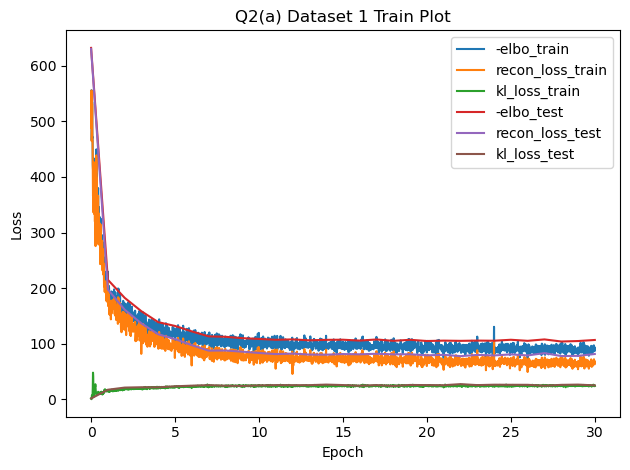

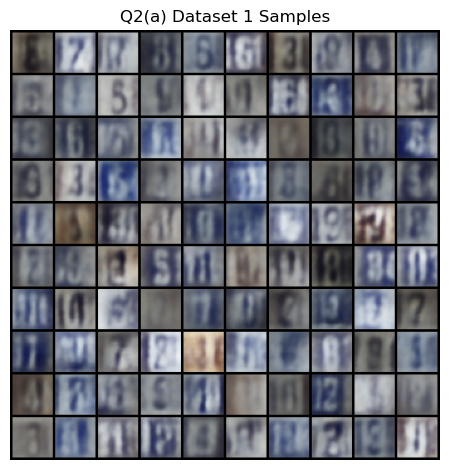

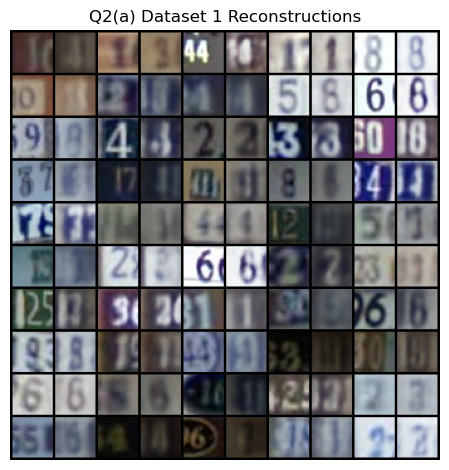

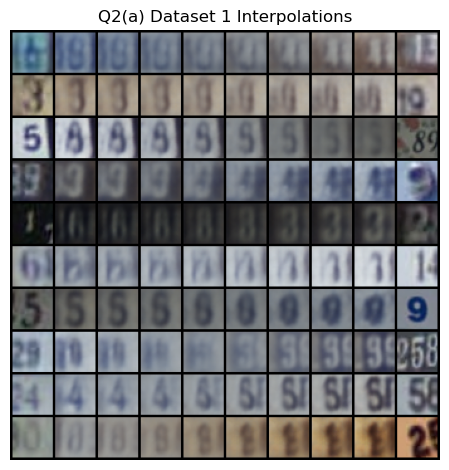

In [17]:
q2_save_results('a', 1, q2_a)

100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


Final -ELBO: 239.3155, Recon Loss: 208.5019, KL Loss: 30.8136


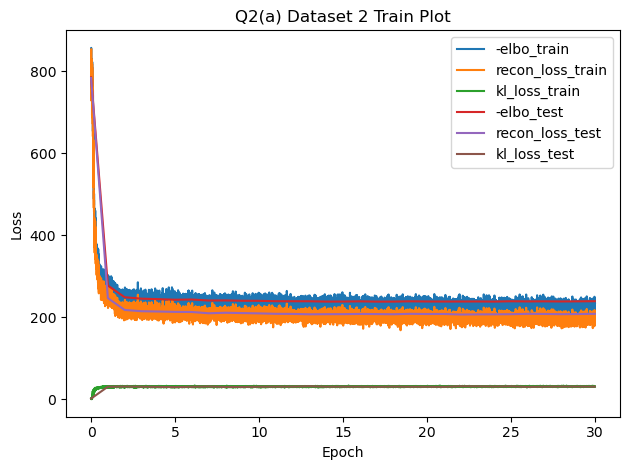

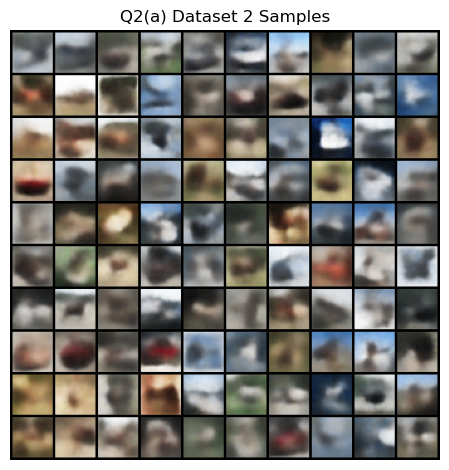

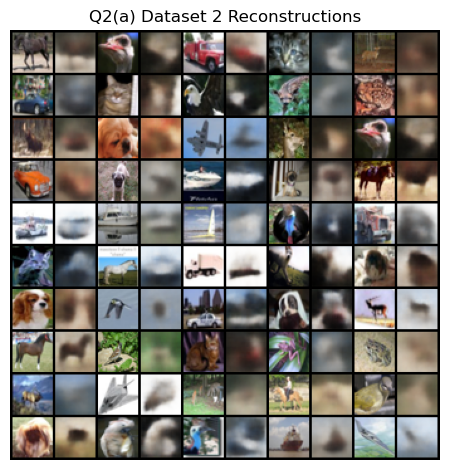

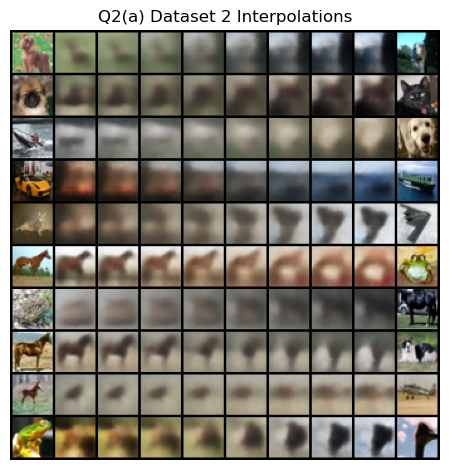

In [18]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNormPerm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNormPerm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNormPerm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNormPerm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNormPerm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [19]:
import copy

class LayerNormPerm(nn.LayerNorm):
    """
    LayerNorm over channel dimension of an image
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        """
        Args:
            x: [B, C, H, W]
        """
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        return x.permute(0, 3, 1, 2)


class HierarchicalVAE(nn.Module):
    def __init__(self):
        super().__init__()

        # q(z1 | x)
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
            LayerNormPerm(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
            LayerNormPerm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
            LayerNormPerm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
            LayerNormPerm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
            LayerNormPerm(64),
            nn.ReLU(),
            nn.Conv2d(64, 12*2, 3, padding=1) # [12*2, 2, 2]
        )
        # q(z2 | x, z1)
        self.encoder2 = copy.deepcopy(self.encoder1)

        # p(z2 | z1)
        self.prior = nn.Sequential(
            nn.Conv2d(12, 32, 3, padding=1), # [32, 2, 2]
            LayerNormPerm(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), # [64, 2, 2]
            LayerNormPerm(64),
            nn.ReLU(),
            nn.Conv2d(64, 12, 3, padding=1) # [12, 2, 2]
        )

        # p(x | z2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
            # TODO: not needed if not scaling inputs
            nn.Tanh()
        )

    def forward(self, x):
        B = x.size(0)
        
        # q(z1 | x)
        z0 = torch.full((B, 12, 2, 2), 0.0).cuda()
        z0 = F.interpolate(z0, size=(32, 32)) # [B, 12, 32, 32]
        # TODO: should z1 depend on x? problem states input to encoder should be all zeros
        # x0 = torch.full_like(x, 0) # [B, 3, 32, 32]
        x_in = torch.cat((x, z0), dim=1)
        mu_z1, sigma_z1 = self.encoder1(x_in).split(12, dim=1)
        sigma_z1 = F.softplus(sigma_z1)
        m = Normal(mu_z1, sigma_z1)
        z1 = m.rsample() # [B, 12, 2, 2]

        # p(z2 | z1)
        # fix std to be 1, only learn the mean
        mu_z2 = self.prior(z1) # [B, 12, 2, 2]
        
        # q(z2 | z1, x)
        # parameterized as residual normal
        z1 = F.interpolate(z1, size=(32, 32)) # [B, 12, 32, 32]
        x_in = torch.cat((x, z1), dim=1)
        delta_mu_z2, delta_sigma_z2 = self.encoder2(x_in).split(12, dim=1)
        delta_sigma_z2 = F.softplus(delta_sigma_z2)
        m = Normal(mu_z2 + delta_mu_z2, delta_sigma_z2)
        z2 = m.rsample() # [B, 12, 2, 2]
        
        # p(x | z2)
        x_recon = self.decoder(z2)
        return mu_z1, sigma_z1, mu_z2, delta_mu_z2, delta_sigma_z2, x_recon

    def loss(self, x):
        mu_z1, sigma_z1, _, delta_mu_z2, delta_sigma_z2, x_recon = self(x)

        # mse(x, x_recon): [B, 3, 32, 32]
        recon_loss = F.mse_loss(x_recon, x, reduction='none')

        # kl[q(z1 | x) || p(z1)]
        # the r.v. z1 ~ q(z1)
        rv_qz1 = Normal(mu_z1, sigma_z1)
        # the r.v. z1 ~ p(z1) = N(0, 1)
        rv_pz1 = Normal(torch.full_like(mu_z1, 0), torch.full_like(sigma_z1, 1))
        kl_z1 = kl_divergence(rv_qz1, rv_pz1) # [B, 12]

        # kl[q(z2 | x, z2) || p(z2 | z1)]
        kl_z2 = (delta_mu_z2**2 + delta_sigma_z2 - torch.log(delta_sigma_z2) - 1) * 0.5

        # sum over feature dim
        recon_loss = recon_loss.sum(dim=(1, 2, 3)).mean()
        kl_loss = (kl_z1 + kl_z2).sum(dim=1).mean()
        neg_elbo = recon_loss + kl_loss
        return neg_elbo, recon_loss, kl_loss

    @torch.no_grad
    def sample(self, n_samples):
        # z1 ~ p(z1) = N(0, 1)
        z1 = torch.normal(0, 1, (n_samples, 12, 2, 2)).cuda()
        # z2 ~ p(z2 | z1)
        mu_z2 = self.prior(z1)
        z2 = torch.normal(mu_z2, 1).cuda()
        x = self.decoder(z2)
        x = x.permute(0, 2, 3, 1).detach().cpu().numpy()        
        x = denormalize(x).clip(0, 255).astype(np.uint8)
        return x

    @torch.no_grad
    def interpolate(self, test_data, n_samples=10, len_interpolate=10):
        # sample test set uniformly at random
        n_test = test_data.size(0)
        idx = torch.multinomial(torch.full((n_test,), 1 / n_test), num_samples=n_samples * 2, replacement=True)
        # (20, 3, 32, 32)
        x = test_data[idx, :]
        samples = np.zeros((n_samples * len_interpolate, 32, 32, 3))
        for i in range(n_samples):
            x1 = x[2 * i].unsqueeze(0)
            x2 = x[2 * i + 1].unsqueeze(0)
            _, _, x1_mu_z2, x1_delta_mu_z2, x1_delta_sigma_z2, _ = self(x1)
            _, _, x2_mu_z2, x2_delta_mu_z2, x2_delta_sigma_z2, _ = self(x2)
            # sample z2
            x1_z2 = torch.normal(x1_mu_z2 + x1_delta_mu_z2, x1_delta_sigma_z2)
            x2_z2 = torch.normal(x2_mu_z2 + x2_delta_mu_z2, x2_delta_sigma_z2)
            zs = torch.vstack([(1 - t) * x1_z2 + t * x2_z2 for t in torch.linspace(0, 1, len_interpolate - 2)]) # (8, 16)
            xs = torch.vstack((x1, self.decoder(zs), x2)) # (10, 3, 32, 32)
            xs = xs.permute(0, 2, 3, 1).detach().cpu().numpy() # (10, 32, 32, 3)
            if i == 0:
                samples = xs
            else:
                samples = np.append(samples, xs, axis=0)
        samples = denormalize(samples).clip(0, 255).astype(np.uint8)
        return samples

In [20]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    model = HierarchicalVAE().cuda()
    train_data = torch.tensor(train_data).to(dtype=torch.float32).permute(0, 3, 1, 2).cuda().contiguous()
    test_data = torch.tensor(test_data).to(dtype=torch.float32).permute(0, 3, 1, 2).cuda().contiguous()
    # normalize
    train_data = normalize(train_data)
    test_data = normalize(test_data)

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_args = dict(epochs=20, lr=1e-3)
    train_losses, test_losses = train_epochs_vae(
        model, train_loader, test_loader, train_args)

    x_samples = model.sample(100)    
    x_recon = reconstruct(model, test_data, n_samples=50)
    x_interp = model.interpolate(test_data, n_samples=10, len_interpolate=10)

    return train_losses, test_losses, x_samples, x_recon, x_interp

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Final -ELBO: 80.8696, Recon Loss: 70.2025, KL Loss: 10.6671


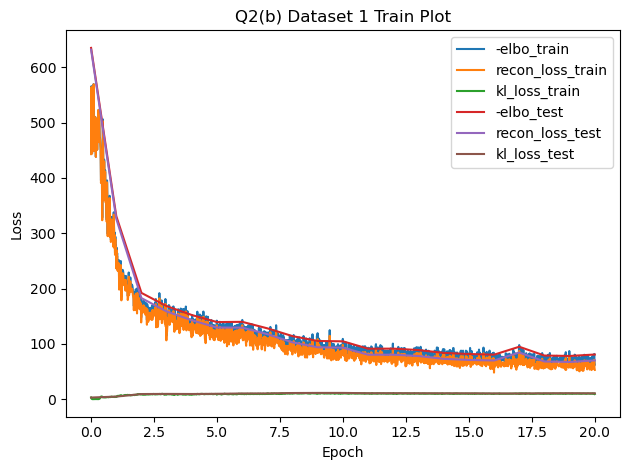

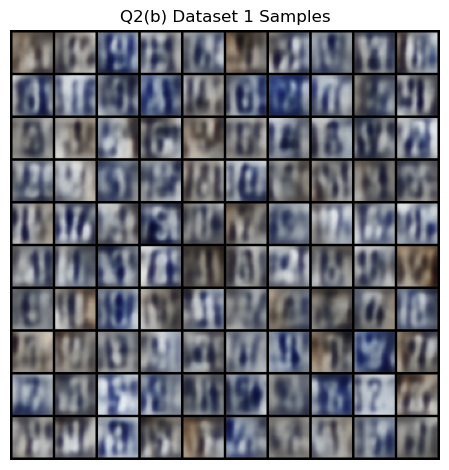

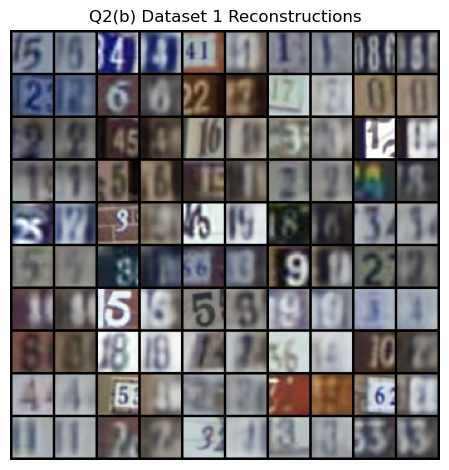

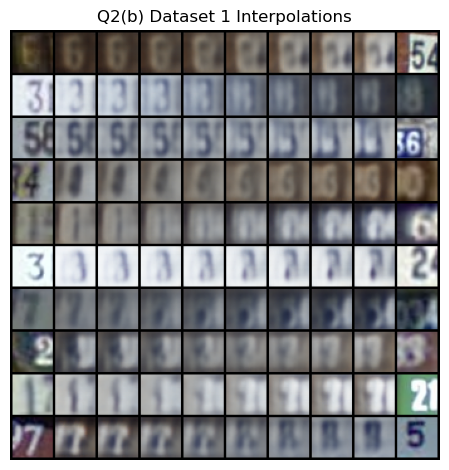

In [21]:
q2_save_results('b', 1, q2_b)

100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


Final -ELBO: 133.5366, Recon Loss: 118.5026, KL Loss: 15.0340


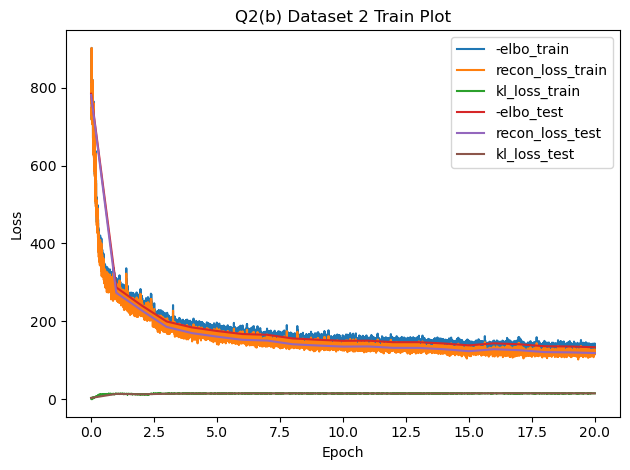

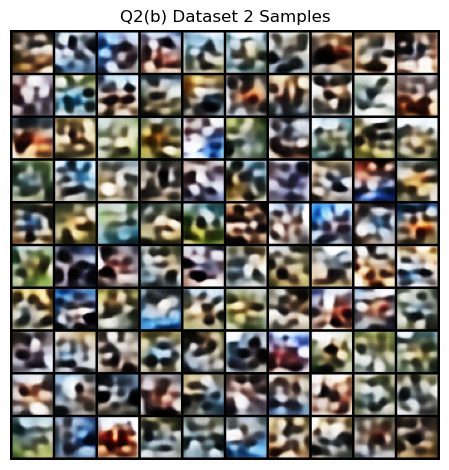

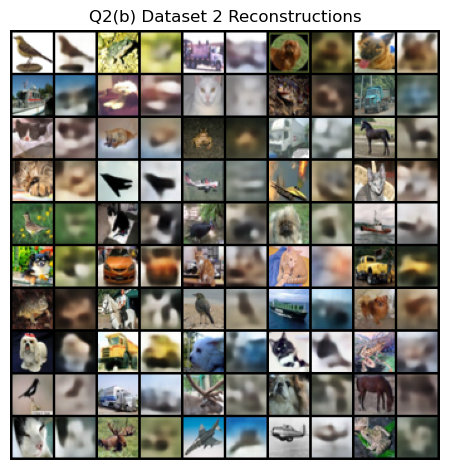

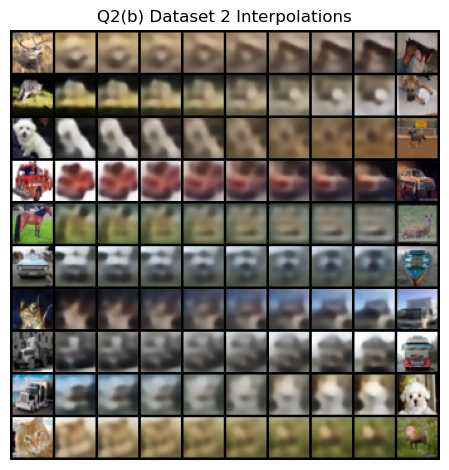

In [22]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [23]:
@dataclass
class TransformerConfig:
    vocab_size: int
    block_size: int
    n_layer: int = 2
    n_head: int = 4
    n_embd: int = 128


"""
Transformer implementation is borrowed from staff solution for HW1
"""
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        # feature projections
        self.kqv_projection = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        

    def forward(self, x, k_cache=None, v_cache=None):
        B, T, C = x.size()  

        # calculate q, k v
        q, k, v = self.kqv_projection(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        if k_cache is not None:
            assert v_cache is not None
            assert T == 1
            # concat previous cache with new k, v
            v = torch.cat([v_cache, v], dim=2) # (B, nh, 1 + T', hs)
            k = torch.cat([k_cache, k], dim=2) # (B, nh, 1 + T', hs)
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # (B, nh, 1, 1 + T')
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))

        att = F.softmax(att, dim=-1)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        return self.proj(y), k, v


class Block(nn.Module):
    """Transfromer Block"""
    
    def __init__(self, config):
        super().__init__()
        self.ln = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        
        self.mlp_sequence = nn.Sequential(
            nn.LayerNorm(config.n_embd),
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        )

    def forward(self, x, k_cache=None, v_cache=None):
        _x = x
        x, k, v = self.attn(self.ln(x), k_cache, v_cache)
        x = _x + x
        x = x + self.mlp_sequence(x)
        return x, k, v


class Transformer(nn.Module):
    """Simple Transformer"""

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.token_embeddings = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embeddings = nn.Embedding(config.block_size, config.n_embd)
        self.transformer_blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.layer_norm = nn.LayerNorm(config.n_embd)

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, start_idx=0, k_cache=None, v_cache=None):
        device = idx.device
        b, t = idx.size()
        assert (t <= self.block_size)
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) + start_idx  

        tok_emb = self.token_embeddings(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.position_embeddings(pos)  # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb

        k_s = []
        v_s = []
        for idx, block in enumerate(self.transformer_blocks):
            if k_cache is not None:
                assert v_cache is not None
                k_i, v_i = k_cache[idx], v_cache[idx]
            else:
                k_i, v_i = None, None 
            x, k, v = block(x, k_i, v_i)
            k_s.append(k)
            v_s.append(v)

        logits = self.lm_head(self.layer_norm(x))
        return logits, k_s, v_s

    def loss(self, x):
        x_in, targets = x[:, :-1], x[:, 1:] # make target a shifted version of the original
        logits, _, _ = self(x_in)
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-1
        )
        return loss

    @torch.no_grad()
    def generate(
        self, idx, max_new_tokens=None, temperature=1.0, cache=False, logit_mask=None
    ):
        """generate

        Args:
            idx (torch.Tensor): input indices
            max_new_tokens (int, optional): maximum number of tokens to generate. Defaults to None.
            temperature (float, optional): temperature for sampling. Defaults to 1.0.
            cache (bool, optional): whether to use caching. Defaults to False.
            logit_mask (torch.Tensor, optional): mask to apply to logits. Defaults to None, of shape (vocab_size,).
        """
        if max_new_tokens == None:
            max_new_tokens = self.block_size - idx.shape[-1]

        if logit_mask == None:
            logit_mask = torch.ones(self.vocab_size, dtype=int) 
            logit_mask[-1] = 0 # ignore last token, by default (usually sos)
            
        k_cache = None
        v_cache = None
           
        time_list = []
        for i in range(max_new_tokens):
            start_time = time.time()
            if cache:
                start_index = i
                idx_in = idx[:, -1:]
            else:
                start_index = 0
                idx_in = idx
            
            logits, k, v = self(idx_in, start_idx=start_index, k_cache=k_cache, v_cache=v_cache)
            if cache:
                k_cache = k
                v_cache = v

            # sample a token from the logits
            logits = logits[:, -1, :] / temperature
            if logit_mask is not None:
                logits[:, logit_mask == 0] = float("-inf") # mask out certain tokens

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

            time_list.append(time.time() - start_time)

            # append sampled token
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, time_list

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        out = self.block(x)
        return x + out


class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        K = 128
        D = 256
        # initialize each element in Unif[-1/K, 1/K]
        self.codebook = nn.Embedding(K, D)
        nn.init.uniform_(self.codebook.weight, -1/K, 1/K)
        
        # encoder: x --> z ~ mu(x), log_sigma(x)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, 2, 1), # 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 4, 2, 1), # 8 x 8
            ResidualBlock(256),
            ResidualBlock(256)
        )
        
        # decoder: z --> x ~ mu(z), log_sigma(z)
        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 4, 2, 1), # 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 3, 4, 2, 1), # 32 x 32
            nn.Tanh()
        )

    def forward(self, x):
        B = x.size(0)
        H, W, D = 8, 8, 256
        z_e = self.encoder(x) # [B, D, H, W]

        z_e_flat = z_e.permute(0, 2, 3, 1).reshape((B*H*W, D)) # [B*H*W, D]
        # [1, B*H*W, D], [1, K, D] --> [B*H*W, K]
        distances = torch.cdist(z_e_flat.unsqueeze(0), self.codebook.weight.unsqueeze(0)).squeeze()
        tokens = torch.argmin(distances, dim=1) # [B*H*W]
        z_q_flat = self.codebook(tokens) # [B*H*W, D]
        z_q = z_q_flat.reshape((B, H, W, D)).permute(0, 3, 1, 2) # [B, D, H, W]

        # straight-through estimator to allow gradient to flow through z_q
        x_recon = self.decoder((z_q - z_e).detach() + z_e)
        return z_e, z_q, tokens, x_recon

    def loss(self, x):
        B = x.size(0)
        z_e, z_q, _, x_recon = self(x)
        # mse(x, x_recon): [B, 3, 32, 32]
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        # vq loss: sg[z_e] - z_q
        vq_loss = F.mse_loss(z_e.detach(), z_q, reduction='mean')
        # commitment loss: z_e - sg[z_q]
        commit_loss = F.mse_loss(z_e, z_q.detach(), reduction='mean')
        loss = recon_loss + vq_loss + commit_loss
        # print(f'ze: {z_e.norm().item():.2f}, z_q: {z_q.norm().item():.2f}')
        return loss

    @torch.no_grad
    def sample(self, prior_model, n_samples=100):
        # sample tokens from trained prior model 
        prior_model.eval()
        bos_token = 128
        idx = torch.ones(n_samples, 1).long().cuda() * bos_token
        generated =  prior_model.generate(idx)
        sequence, _ = generated
        sequence = sequence[:, 1:] # remove bos token, [B, H*W]

        tokens = sequence.view(-1, 8, 8) # codebook tokens, [B, H, W]
        z_q = self.codebook(tokens) # [B, H, W, D]
        z_q = z_q.permute(0, 3, 1, 2) # [B, D, H, W]
        x = self.decoder(z_q)
        x = x.permute(0, 2, 3, 1).detach().cpu().numpy()        
        x = denormalize(x).clip(0, 255).astype(np.uint8)
        return x


def build_token_dataset(dataset, vqvae):
    """
    Pass the image data through a trained vqvae to generate
    categorical latents to train the transformer prior
    i.e. for each pixel, the index in 0, ..., 127
    that indexes the codebook
    
    Args:
        dataset: torch.tensor (B, 3, 32, 32), normalized to [-1, 1]
        vqvae: a trained vqvae model

    Returns:
        loader: torch.tensor for the categorical latents
    """
    H, W = 8, 8
    vqvae.eval()
    token_dataset = []
    with torch.no_grad():
        for x in  data.DataLoader(dataset, batch_size=128):
            x = x.cuda().contiguous()
            _, _,tokens, _ = vqvae(x) # (B*H*W)
            tokens = tokens.view(-1, H*W) # (B, H*W)
            token_dataset.append(tokens)
        token_dataset = torch.vstack(token_dataset)
    return token_dataset

In [25]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    vqvae = VQVAE().cuda()
    H, W = 8, 8
    tf_config = TransformerConfig(
      vocab_size=128 + 1,
      block_size=H * W + 1, # plus one for sos token
    )
    transformer = Transformer(tf_config).cuda()

    vqvae_train_args = dict(epochs=20, lr=1e-3)
    tf_train_args = dict(epochs=20, lr=1e-3, grad_clip=1, use_cos_decay=True, warmup=1000)
    
    train_data = torch.tensor(train_data).to(dtype=torch.float32).permute(0, 3, 1, 2).cuda().contiguous()
    test_data = torch.tensor(test_data).to(dtype=torch.float32).permute(0, 3, 1, 2).cuda().contiguous()
    # normalize
    train_data = normalize(train_data)
    test_data = normalize(test_data)

    # train vqvae
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    vqvae_train_losses, vqvae_test_losses = train_epochs(
        vqvae, train_loader, test_loader, vqvae_train_args)

    # train transformer
    tf_train_data = build_token_dataset(train_data, vqvae)
    tf_test_data = build_token_dataset(test_data, vqvae)
    tf_train_loader = data.DataLoader(tf_train_data, batch_size=128, shuffle=True)
    tf_test_loader = data.DataLoader(tf_test_data, batch_size=128)
    tf_train_losses, tf_test_losses = train_epochs(
        transformer, tf_train_loader, tf_test_loader, tf_train_args)

    x_samples = vqvae.sample(transformer, 100)    
    x_recon = reconstruct(vqvae, test_data, n_samples=50)

    return vqvae_train_losses, vqvae_test_losses, tf_train_losses, tf_test_losses, x_samples, x_recon

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


VQ-VAE Final Test Loss: 0.1265
Transformer Prior Final Test Loss: 1.5215


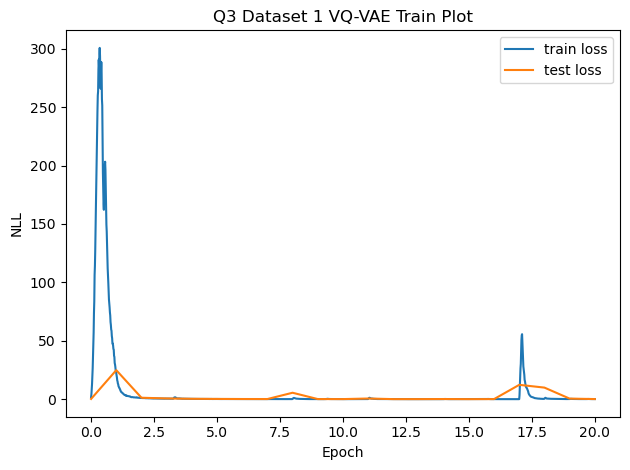

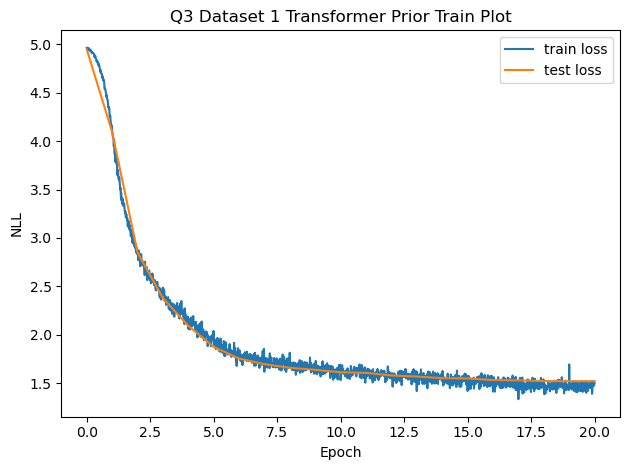

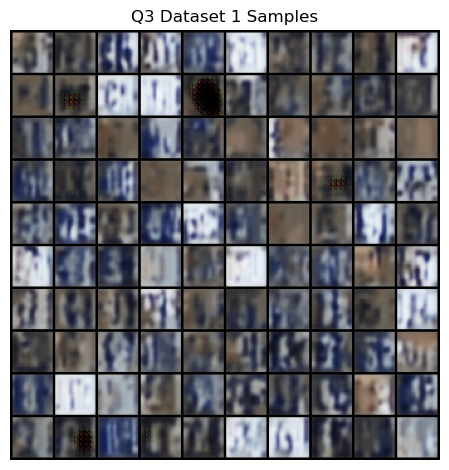

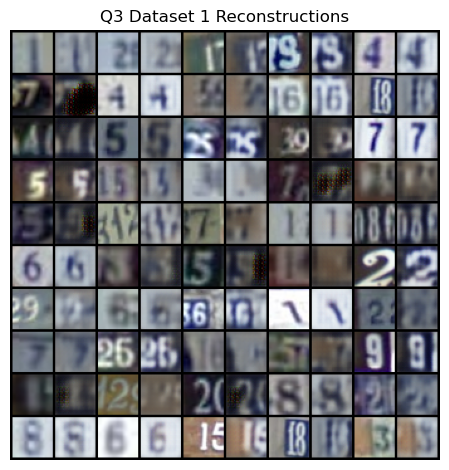

In [28]:
q3_save_results(1, q3)

100%|██████████| 20/20 [00:42<00:00,  2.10s/it]


VQ-VAE Final Test Loss: 0.0598
Transformer Prior Final Test Loss: 2.5821


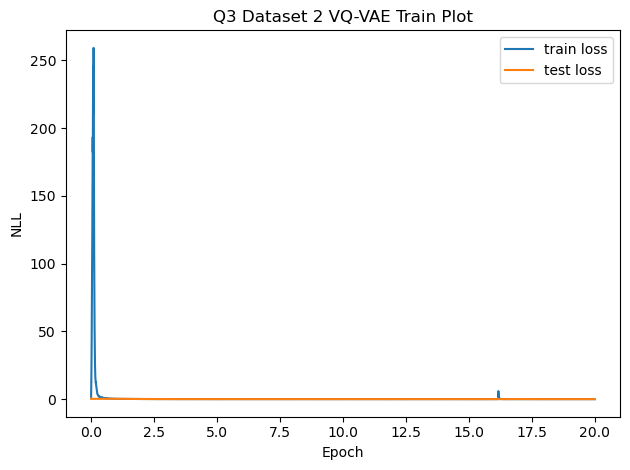

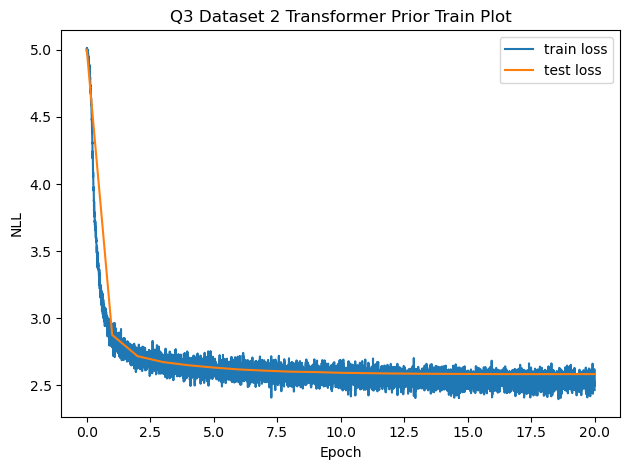

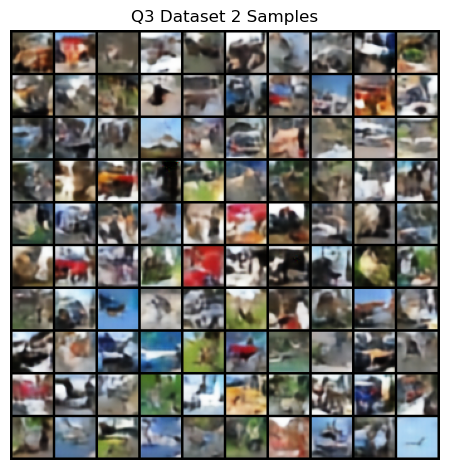

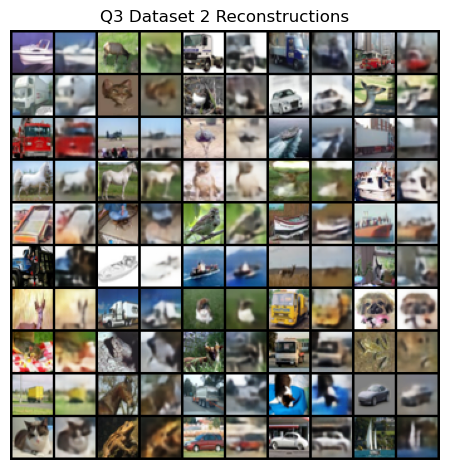

In [27]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)